# 🤖 AI Face Emotion Detection - Model Retraining

This notebook retrains the emotion detection model using user feedback data collected from the app.

## Workflow:
1. **Load Feedback Data** - From CSV and images
2. **Visualize Data** - Check what was corrected
3. **Fine-tune Model** - Retrain with feedback
4. **Evaluate Performance** - Compare old vs new
5. **Update Model** - Replace original with improved version

In [46]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 📁 Configuration

Set up paths and emotion labels.

In [47]:
# Configuration
import os

# Get the current working directory (where the notebook is)
BASE_DIR = os.getcwd()
FEEDBACK_CSV = os.path.join(BASE_DIR, "feedback_log.csv")
FEEDBACK_IMAGES_DIR = os.path.join(BASE_DIR, "feedback_images")
MODEL_PATH = os.path.join(BASE_DIR, "best_emotion_model.keras")
RETRAINED_MODEL_PATH = os.path.join(BASE_DIR, "best_emotion_model_retrained.keras")

EMOTION_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(f"📂 Feedback CSV: {FEEDBACK_CSV}")
print(f"📂 Images Directory: {FEEDBACK_IMAGES_DIR}")
print(f"📂 Model Path: {MODEL_PATH}")

📂 Feedback CSV: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\feedback_log.csv
📂 Images Directory: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\feedback_images
📂 Model Path: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model.keras


## 📊 Load & Analyze Feedback Data

Load the feedback data and visualize what users corrected.

In [48]:
# Load feedback CSV
if not os.path.exists(FEEDBACK_CSV):
    print("❌ No feedback data found. Run the app first to collect feedback.")
else:
    df = pd.read_csv(FEEDBACK_CSV)
    
    # Clean data - remove rows with missing critical data
    df = df.dropna(subset=['image_path', 'corrected_emotion', 'timestamp'])
    
    # Convert confidence to float if it's not already
    df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
    
    # Convert timestamp to datetime (handles mixed formats)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Remove any rows where timestamp conversion failed
    df = df.dropna(subset=['timestamp'])
    
    print(f"✅ Found {len(df)} feedback records\n")
    display(df)

✅ Found 15 feedback records



,timestamp,predicted_emotion,confidence,corrected_emotion,image_path
0,2026-02-27 01:40:00,Surprise,0.5634,Angry,20260227_014052_861697_Surprise_to_Angry.png
1,2026-02-27 01:45:00,Sad,0.9703,Sad,20260227_014558_391505_Sad_to_Sad.png
2,2026-02-27 01:46:00,Sad,0.9703,Sad,20260227_014603_171653_Sad_to_Sad.png
3,2026-02-27 01:46:00,Sad,0.9900,Neutral,20260227_014628_334942_Sad_to_Neutral.png
4,2026-02-27 01:46:00,Happy,0.9997,Happy,20260227_014654_460479_Happy_to_Happy.png
5,2026-02-27 02:12:00,Happy,0.9887,Happy,20260227_021234_276662_Happy_to_Happy.png
6,2026-02-27 02:12:00,Happy,0.9999,Happy,20260227_021242_775291_Happy_to_Happy.png
7,2026-02-27 02:13:00,Sad,0.9592,Neutral,20260227_021309_393170_Sad_to_Neutral.png
8,2026-02-27 02:13:00,Surprise,0.9398,Happy,20260227_021330_853333_Surprise_to_Happy.png
9,2026-02-27 02:13:00,Happy,1.0000,Happy,20260227_021341_247300_Happy_to_Happy.png


### 📈 Visualize Feedback Statistics

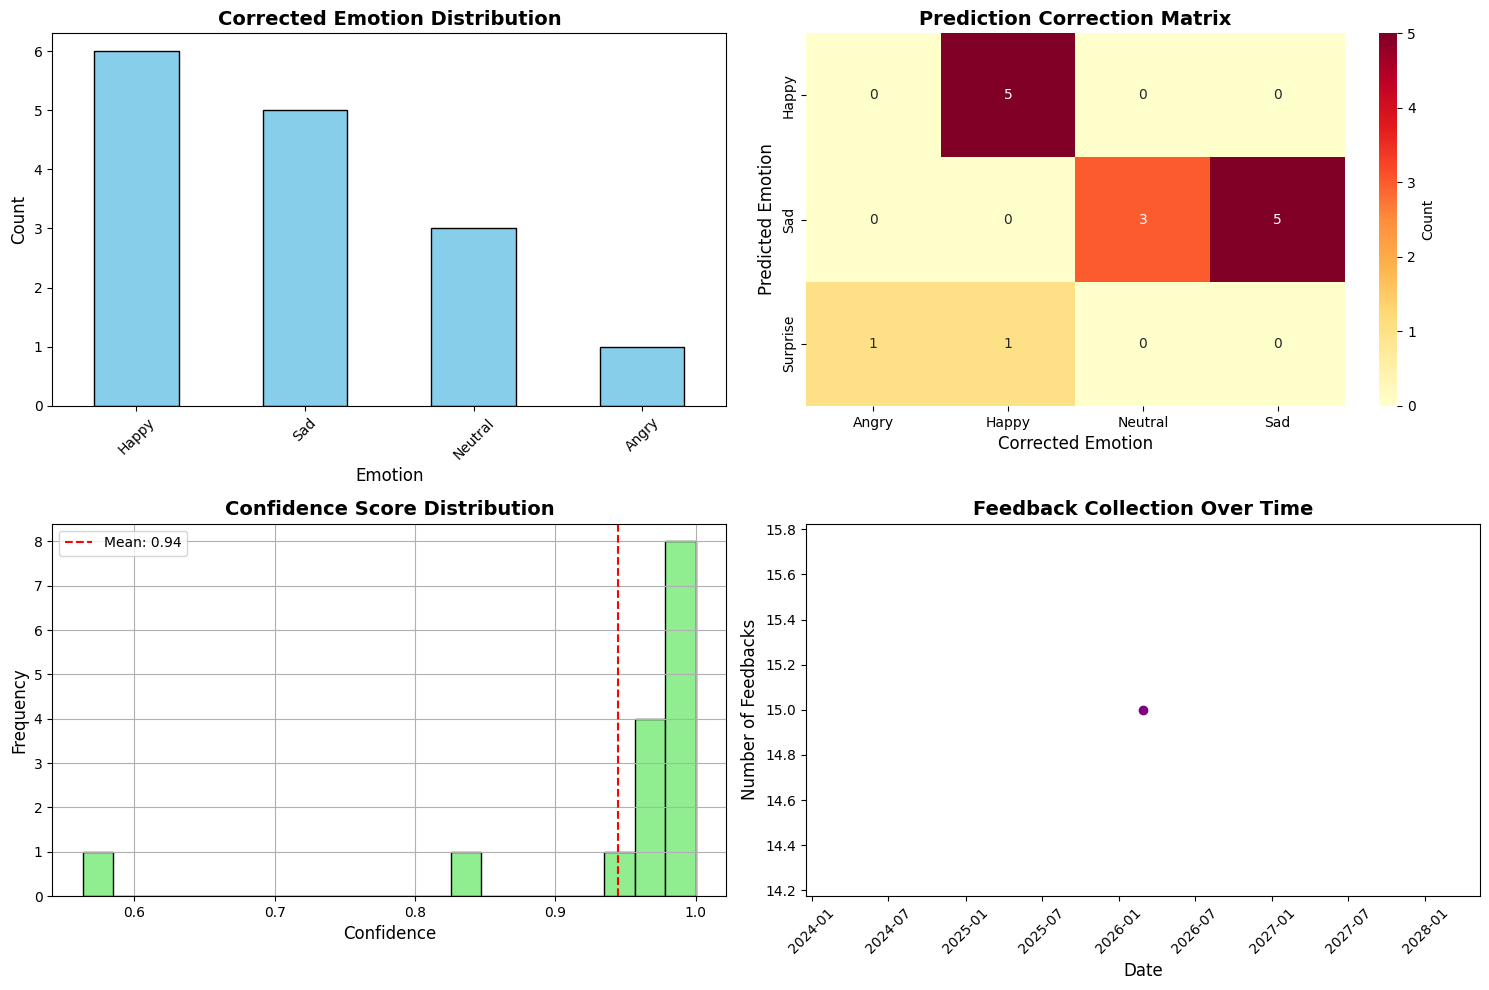


📊 Summary Statistics:
   Total feedbacks: 15
   Average confidence: 0.9444
   Date range: 2026-02-27 01:40:00 to 2026-02-27 02:15:00


In [49]:
# Visualize feedback statistics
if 'df' not in locals() or df is None or len(df) == 0:
    print("❌ No feedback data loaded. Please run the previous cell first.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Predicted vs Corrected Emotions
    ax1 = axes[0, 0]
    emotion_counts = df['corrected_emotion'].value_counts()
    emotion_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
    ax1.set_title('Corrected Emotion Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emotion', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # 2. Correction matrix (predicted -> corrected)
    ax2 = axes[0, 1]
    correction_matrix = pd.crosstab(df['predicted_emotion'], df['corrected_emotion'])
    sns.heatmap(correction_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Count'})
    ax2.set_title('Prediction Correction Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Corrected Emotion', fontsize=12)
    ax2.set_ylabel('Predicted Emotion', fontsize=12)

    # 3. Confidence distribution
    ax3 = axes[1, 0]
    df['confidence'].hist(bins=20, ax=ax3, color='lightgreen', edgecolor='black')
    ax3.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Confidence', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.axvline(df['confidence'].mean(), color='red', linestyle='--', label=f'Mean: {df["confidence"].mean():.2f}')
    ax3.legend()

    # 4. Feedbacks over time
    ax4 = axes[1, 1]
    df.groupby(df['timestamp'].dt.date).size().plot(kind='line', marker='o', ax=ax4, color='purple')
    ax4.set_title('Feedback Collection Over Time', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Number of Feedbacks', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Summary Statistics:")
    print(f"   Total feedbacks: {len(df)}")
    print(f"   Average confidence: {df['confidence'].mean():.4f}")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

### 🖼️ Display Sample Feedback Images

View some of the images that were corrected.

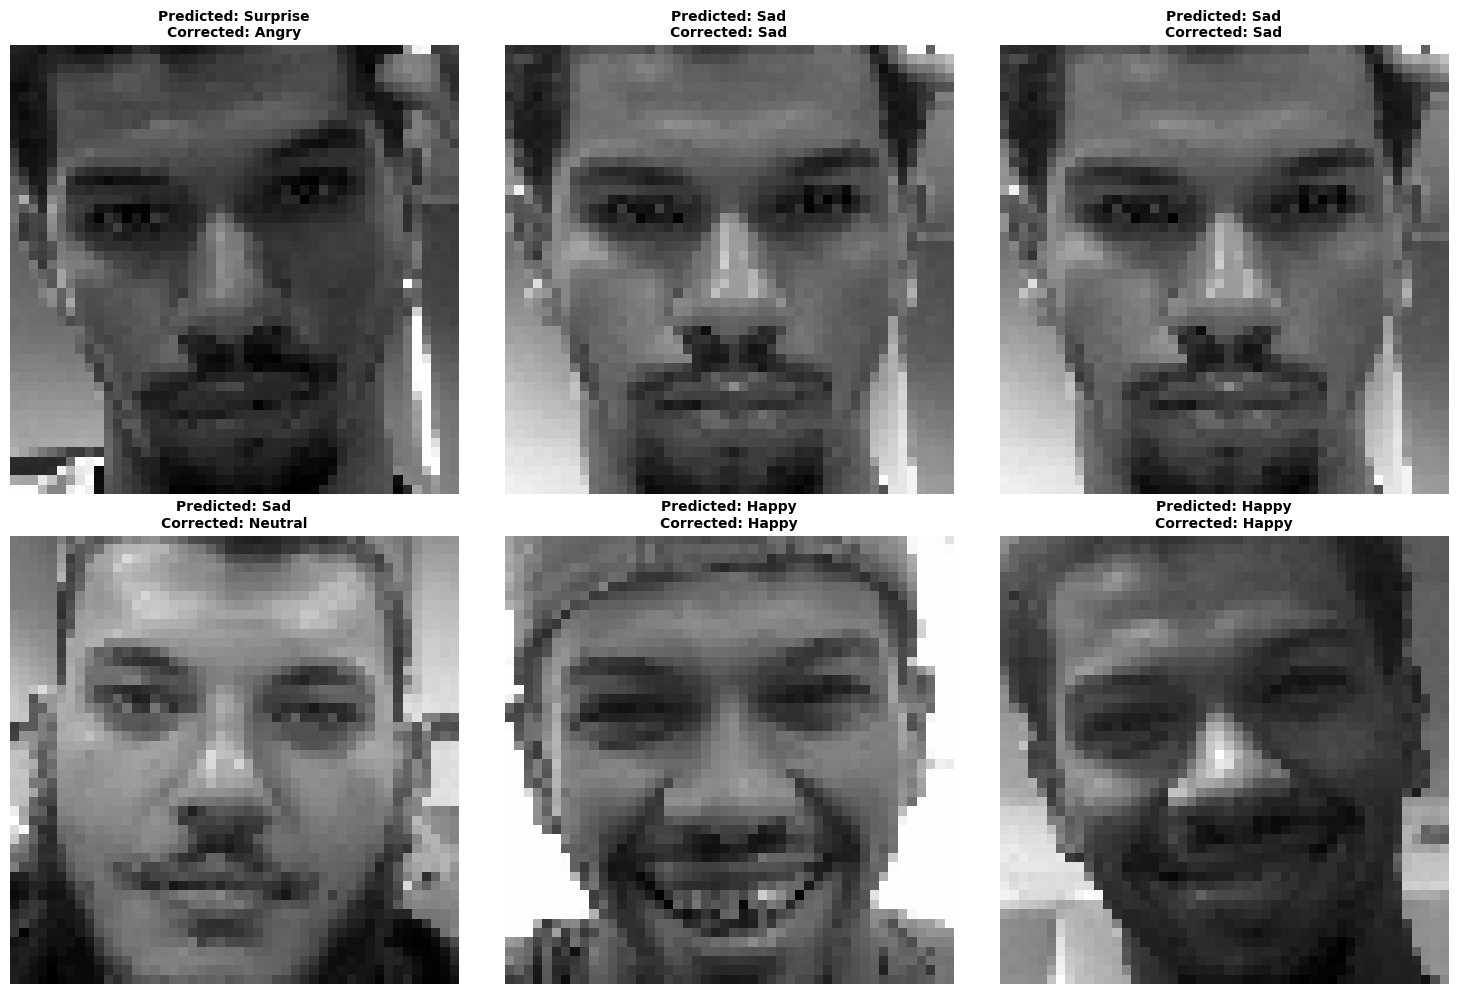

In [50]:
# Display sample feedback images
if 'df' not in locals() or df is None or len(df) == 0:
    print("❌ No feedback data loaded. Please run the previous cells first.")
else:
    num_samples = min(6, len(df))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx in range(num_samples):
        row = df.iloc[idx]
        image_path = os.path.join(FEEDBACK_IMAGES_DIR, row['image_path'])
        
        if os.path.exists(image_path):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(f"Predicted: {row['predicted_emotion']}\nCorrected: {row['corrected_emotion']}", 
                                   fontsize=10, fontweight='bold')
            else:
                axes[idx].text(0.5, 0.5, 'Failed to Load', ha='center', va='center')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
            axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## 🔄 Load Feedback Data for Training

Prepare images and labels for model retraining.

In [51]:
# Load feedback data
if 'df' not in locals() or df is None or len(df) == 0:
    print("❌ No feedback data loaded. Please run the previous cells first.")
    X = None
    y = None
else:
    X = []  # Images
    y = []  # Labels

    for idx, row in df.iterrows():
        image_filename = str(row['image_path']).strip()
        correct_emotion = str(row['corrected_emotion']).strip()
        
        image_path = os.path.join(FEEDBACK_IMAGES_DIR, image_filename)
        
        if os.path.exists(image_path):
            # Load image
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = img / 255.0  # Normalize
                X.append(img)
                y.append(EMOTION_LABELS.index(correct_emotion))
                print(f"  ✅ Loaded: {image_filename} → {correct_emotion}")
            else:
                print(f"  ❌ Failed to load: {image_filename}")
        else:
            print(f"  ❌ Image not found: {image_path}")

    if len(X) == 0:
        print("\n❌ No valid images loaded!")
        X = None
        y = None
    else:
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)

        # Reshape for model input (batch, height, width, channels)
        X = X.reshape(-1, 48, 48, 1)

        print(f"\n📊 Data Summary:")
        print(f"   Total samples: {len(X)}")
        print(f"   Shape: {X.shape}")
        print(f"   Labels shape: {y.shape}")
        print(f"   Min/Max pixel values: {X.min():.2f} / {X.max():.2f}")

  ✅ Loaded: 20260227_014052_861697_Surprise_to_Angry.png → Angry
  ✅ Loaded: 20260227_014558_391505_Sad_to_Sad.png → Sad
  ✅ Loaded: 20260227_014603_171653_Sad_to_Sad.png → Sad
  ✅ Loaded: 20260227_014628_334942_Sad_to_Neutral.png → Neutral
  ✅ Loaded: 20260227_014654_460479_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_021234_276662_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_021242_775291_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_021309_393170_Sad_to_Neutral.png → Neutral
  ✅ Loaded: 20260227_021330_853333_Surprise_to_Happy.png → Happy
  ✅ Loaded: 20260227_021341_247300_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_021412_006306_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_021423_143893_Sad_to_Sad.png → Sad
  ✅ Loaded: 20260227_021441_857224_Sad_to_Neutral.png → Neutral
  ✅ Loaded: 20260227_021453_758807_Sad_to_Sad.png → Sad
  ✅ Loaded: 20260227_021506_764883_Sad_to_Sad.png → Sad

📊 Data Summary:
   Total samples: 15
   Shape: (15, 48, 48, 1)
   Labels shape: (15,)
 

## 🧠 Load Original Model

Load the current model that will be fine-tuned.

In [52]:
# Load original model
print("🔄 Loading original model...")
model = load_model(MODEL_PATH)

print("\n📈 Model Architecture:")
model.summary()

🔄 Loading original model...

📈 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,162,327 (80.73 MB)

 Trainable params: 7,052,487 (26.90 MB)

 Non-trainable params: 4,864 (19.00 KB)

 Optimizer params: 14,104,976 (53.81 MB)

## 🚀 Fine-Tune Model with Feedback Data

Retrain the model with data augmentation to improve generalization.

In [53]:
# Compile model with lower learning rate for fine-tuning
if X is None or y is None:
    print("❌ No training data available. Please run the previous cells first.")
else:
    optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data augmentation to improve generalization
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )

    print("🚀 Starting fine-tuning...")
    print(f"   Epochs: 10")
    print(f"   Batch size: 8")
    print(f"   Samples: {len(X)}")
    print(f"   Learning rate: 0.0001\n")

    # Fine-tune with the feedback data
    history = model.fit(
        datagen.flow(X, y, batch_size=8),
        epochs=10,
        verbose=1,
        steps_per_epoch=max(1, len(X) // 8)
    )

    print("\n✅ Fine-tuning complete!")

🚀 Starting fine-tuning...
   Epochs: 10
   Batch size: 8
   Samples: 15
   Learning rate: 0.0001

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.1429 - loss: 3.6053
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6250 - loss: 4.1445
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.2857 - loss: 3.7012
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3750 - loss: 5.4377
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.3750 - loss: 4.2206
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1429 - loss: 6.8508
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2857 - loss: 2.8347
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1250 - loss: 4.4311
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4286 - loss: 4.5804
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2500 - loss: 6.2224

✅ Fine-tuning complete!


## 📊 Visualize Training Results

Plot the training loss and accuracy curves.

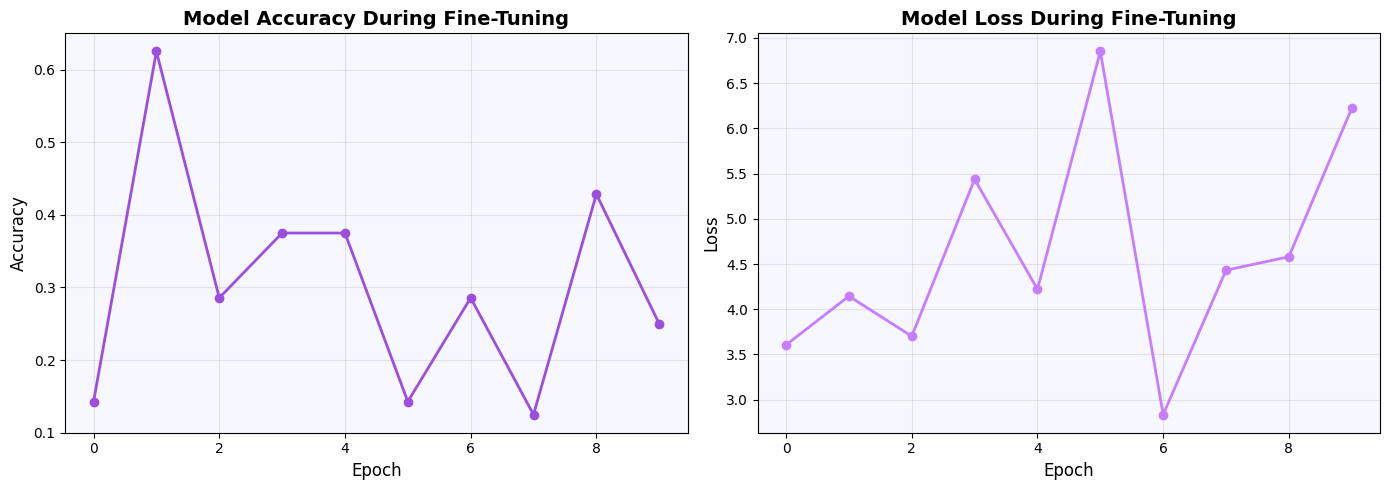


📊 Training Summary:
   Final Accuracy: 0.2500
   Final Loss: 6.2224


In [54]:
# Plot training progress
if 'history' not in locals() or history is None:
    print("⚠️ No training history available. Please run the training cell first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], marker='o', linewidth=2, color='#9D4EDD')
    axes[0].set_title('Model Accuracy During Fine-Tuning', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_facecolor('#f7f7ff')

    # Plot loss
    axes[1].plot(history.history['loss'], marker='o', linewidth=2, color='#C77DFF')
    axes[1].set_title('Model Loss During Fine-Tuning', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_facecolor('#f7f7ff')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Training Summary:")
    print(f"   Final Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"   Final Loss: {history.history['loss'][-1]:.4f}")

## 💾 Save Retrained Model

Save the improved model.

In [55]:
# Evaluate on feedback data
if 'model' not in locals() or model is None or X is None or y is None:
    print("⚠️ Model or training data not available. Please run previous cells first.")
else:
    loss, accuracy = model.evaluate(X, y, verbose=0)
    print(f"📊 Evaluation on Feedback Data:")
    print(f"   Loss: {loss:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")

📊 Evaluation on Feedback Data:
   Loss: 2.3832
   Accuracy: 0.6667


## 🔄 Replace Original Model (Optional)

This will backup the old model and replace it with the new one.

**⚠️ Warning:** This will update the model used by your Streamlit app!

In [56]:
# Save the retrained model
if 'model' not in locals() or model is None:
    print("⚠️ No model available to save. Please run the training cells first.")
else:
    # Backup original model if not already backed up
    MODEL_BACKUP = os.path.join(BASE_DIR, "best_emotion_model_backup.keras")
    if not os.path.exists(MODEL_BACKUP):
        import shutil
        shutil.copy(MODEL_PATH, MODEL_BACKUP)
        print(f"✅ Backed up original model to: {MODEL_BACKUP}")
    else:
        print(f"ℹ️  Backup already exists: {MODEL_BACKUP}")

    # Save retrained model
    model.save(RETRAINED_MODEL_PATH)
    print(f"✅ Retrained model saved to: {RETRAINED_MODEL_PATH}")
    print(f"\n📝 Next Steps:")
    print(f"   1. Test the retrained model in your app")
    print(f"   2. If it performs well, replace the original model:")
    print(f"      - Rename '{os.path.basename(RETRAINED_MODEL_PATH)}' to '{os.path.basename(MODEL_PATH)}'")
    print(f"   3. If it doesn't work well, restore from backup:")
    print(f"      - Copy '{os.path.basename(MODEL_BACKUP)}' to '{os.path.basename(MODEL_PATH)}'")
    print(f"   4. Continue collecting feedback for better improvements!")

ℹ️  Backup already exists: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model_backup.keras
✅ Retrained model saved to: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model_retrained.keras

📝 Next Steps:
   1. Test the retrained model in your app
   2. If it performs well, replace the original model:
      - Rename 'best_emotion_model_retrained.keras' to 'best_emotion_model.keras'
   3. If it doesn't work well, restore from backup:
      - Copy 'best_emotion_model_backup.keras' to 'best_emotion_model.keras'
   4. Continue collecting feedback for better improvements!


## 🎯 Summary

### What We Did:
1. ✅ Loaded feedback records from users
2. ✅ Visualized correction patterns and statistics
3. ✅ Fine-tuned the model with feedback data
4. ✅ Saved the improved model

### Next Steps:
1. Run your Streamlit app to test the improved model
2. Continue collecting feedback to further improve accuracy
3. Retrain periodically (weekly/monthly) as more feedback accumulates

### Model Files:
- **best_emotion_model.keras** - Active model (used by app)
- **best_emotion_model_backup.keras** - Previous version
- **best_emotion_model_retrained.keras** - Latest retrained version

---

**🚀 Happy Training!**